In [4]:
import requests
import json
import csv
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow import config
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer
from keras.callbacks import EarlyStopping


In [5]:
config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Get the data from Binance api

## Get

In [6]:
# You can create 'api_key.txt' file with your api key inside it (it's already in '.gitignore')
# or just replace 'api_key.txt' => 'your_api_key'
api_key = open('api_key.txt', 'r').read()

endpoint = 'https://api.binance.com/api/v3/klines'

symbol =  'BTCUSDT'
interval =  '1h'
limit = 1000
headers = {
    'X-MBX-APIKEY': api_key
}

# Get current date, one year ago
start_time = int((time.time() - 31536000) * 1000) # 31536000 seconds = 1 year
end_time = int(time.time() * 1000)

results = []

# Loop through the data until there is no more left
while True:
    # Make the initial request with these parameters
    params = {'symbol': symbol, 'interval': interval, 'startTime': start_time, 'endTime': end_time, 'limit': limit}
    response = requests.get(endpoint, headers=headers, params=params)

    # Check if there is any data left
    if not response.json():
        break

    # Append the data to the results list
    results.extend(response.json())

    # Set the start time for the next request
    start_time = int(results[-1][0]) + 1


## Define dataframe columns and create datafile

In [7]:
columns = ['open_time', 'open_price', 'high_price', 'low_price',
            'close_price', 'Volume', 'close_time', 'quote_asset_volume',
            'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

df = pd.DataFrame(results, columns=columns)


In [8]:
df = df[['open_time', 'open_price']]

with open('data.csv', 'w') as file:
    file.write(df.to_csv())

In [9]:
df

,open_time,open_price
0,1650578400000,40726.46000000
1,1650582000000,40412.00000000
2,1650585600000,40480.01000000
3,1650589200000,40427.23000000
4,1650592800000,40501.23000000
...,...,...
8754,1682096400000,28042.71000000
8755,1682100000000,27901.64000000
8756,1682103600000,27783.97000000
8757,1682107200000,27279.90000000


# Preparing data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759 entries, 0 to 8758
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   open_time   8759 non-null   int64 
 1   open_price  8759 non-null   object
dtypes: int64(1), object(1)
memory usage: 137.0+ KB


### Split df to dates and prices

In [11]:
df_dates = df['open_time']
df_prices = df['open_price']

In [12]:
df_prices

0       40726.46000000
1       40412.00000000
2       40480.01000000
3       40427.23000000
4       40501.23000000
             ...      
8754    28042.71000000
8755    27901.64000000
8756    27783.97000000
8757    27279.90000000
8758    27270.87000000
Name: open_price, Length: 8759, dtype: object

### Change df_prices type from object to float

In [13]:
df_prices = df_prices.astype(float)

In [14]:
df_prices

0       40726.46
1       40412.00
2       40480.01
3       40427.23
4       40501.23
          ...   
8754    28042.71
8755    27901.64
8756    27783.97
8757    27279.90
8758    27270.87
Name: open_price, Length: 8759, dtype: float64

## Split into training, validation and test

In [15]:
train, valid, test = np.split(df_prices, [int(len(df_prices) * 0.65), int(len(df_prices) * 0.75)])

In [16]:
len(train), len(valid), len(test)

(5693, 876, 2190)

# Scale

In [17]:
scaler = MinMaxScaler()

train_norm = scaler.fit_transform(train.values.reshape(-1, 1))
valid_norm = scaler.fit_transform(valid.values.reshape(-1, 1))
test_norm = scaler.fit_transform(test.values.reshape(-1, 1))

## Plot

Text(0, 0.5, 'Exchange rate BTC to USDT')

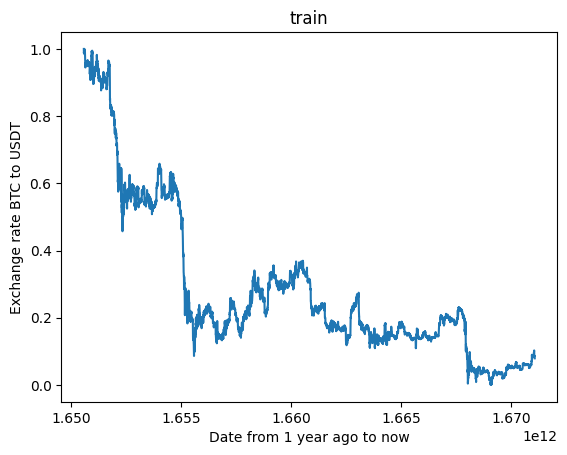

In [18]:
plt.plot(df_dates[:int(len(df_prices) * 0.65)], train_norm)
plt.title('train')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

Text(0, 0.5, 'Exchange rate BTC to USDT')

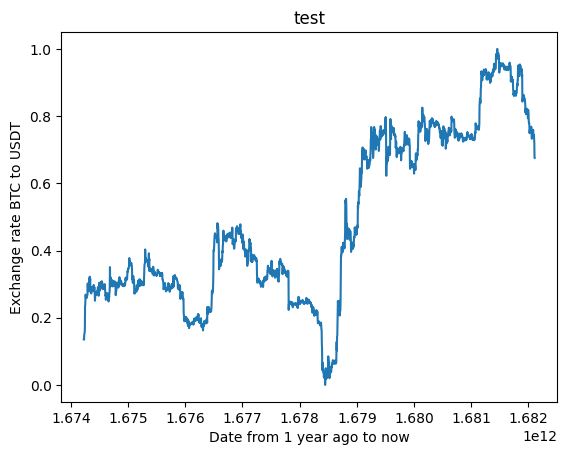

In [19]:
plt.plot(df_dates[int(len(df_prices) * 0.75):], test_norm)
plt.title('test')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

# Arrays => X, y


In [20]:
look_back = 96 # x will be last 96 hours for each y

train_gen = TimeseriesGenerator(train.to_numpy(), train.to_numpy(), length=look_back, batch_size=70)
valid_gen = TimeseriesGenerator(valid.to_numpy(), valid.to_numpy(), length=look_back, batch_size=1)
test_gen = TimeseriesGenerator(test.to_numpy(), test.to_numpy(), length=look_back, batch_size=1)

print('Number of batches in train_gen:', train_gen.__len__())

Number of batches in train_gen: 80


### X for first first batch in train_gen (as pd dataframe)

In [21]:
pd.DataFrame(train_gen.__getitem__(0)[0])

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,40726.46,40412.00,40480.01,40427.23,40501.23,40486.19,40502.10,40628.74,40669.26,40678.10,...,38832.29,38802.64,38735.61,39060.89,38976.76,39469.65,39394.93,39887.04,40225.98,40185.34
1,40412.00,40480.01,40427.23,40501.23,40486.19,40502.10,40628.74,40669.26,40678.10,40709.60,...,38802.64,38735.61,39060.89,38976.76,39469.65,39394.93,39887.04,40225.98,40185.34,40227.57
2,40480.01,40427.23,40501.23,40486.19,40502.10,40628.74,40669.26,40678.10,40709.60,40407.33,...,38735.61,39060.89,38976.76,39469.65,39394.93,39887.04,40225.98,40185.34,40227.57,40346.97
3,40427.23,40501.23,40486.19,40502.10,40628.74,40669.26,40678.10,40709.60,40407.33,40298.26,...,39060.89,38976.76,39469.65,39394.93,39887.04,40225.98,40185.34,40227.57,40346.97,40426.08
4,40501.23,40486.19,40502.10,40628.74,40669.26,40678.10,40709.60,40407.33,40298.26,40459.92,...,38976.76,39469.65,39394.93,39887.04,40225.98,40185.34,40227.57,40346.97,40426.08,40554.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,39752.40,39656.49,39490.00,39421.18,39661.56,39703.74,39499.99,39633.37,39548.31,39450.12,...,39388.51,39321.02,39415.46,39385.01,39634.26,39773.99,39714.94,39679.31,39560.13,39094.46
66,39656.49,39490.00,39421.18,39661.56,39703.74,39499.99,39633.37,39548.31,39450.12,38855.47,...,39321.02,39415.46,39385.01,39634.26,39773.99,39714.94,39679.31,39560.13,39094.46,39287.09
67,39490.00,39421.18,39661.56,39703.74,39499.99,39633.37,39548.31,39450.12,38855.47,39095.81,...,39415.46,39385.01,39634.26,39773.99,39714.94,39679.31,39560.13,39094.46,39287.09,39438.12
68,39421.18,39661.56,39703.74,39499.99,39633.37,39548.31,39450.12,38855.47,39095.81,39091.17,...,39385.01,39634.26,39773.99,39714.94,39679.31,39560.13,39094.46,39287.09,39438.12,39899.43


### y for first batch in train_gen (as pd dataframe)

In [22]:
pd.DataFrame(train_gen.__getitem__(0)[1])

,0
0,40227.57
1,40346.97
2,40426.08
3,40554.71
4,40474.98
...,...
65,39287.09
66,39438.12
67,39899.43
68,40283.71


# Training

In [28]:
data_dim = 1

model = Sequential()

model.add(InputLayer(input_shape=(look_back, data_dim)))
model.add(LSTM(32, return_sequences=True,
               input_shape=(look_back, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))

early_stopping = EarlyStopping(patience=10)

model.compile('adam', loss='mae', metrics=['accuracy'])

model.fit_generator(train_gen, epochs=100, validation_data=valid_gen, callbacks=early_stopping)

Epoch 1/100


C:\Users\Evgeny\AppData\Local\Temp\ipykernel_1332\2256605589.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, epochs=100, validation_data=valid_gen, callbacks=early_stopping)


80/80 [==============================] - 20s 170ms/step - loss: 22549.4121 - accuracy: 0.0000e+00 - val_loss: 17785.6191 - val_accuracy: 0.0000e+00
Epoch 2/100
79/80 [============================>.] - ETA: 0s - loss: 22590.9629 - accuracy: 0.0000e+00